<a href="https://colab.research.google.com/github/fawadmehboob/2D-Rocket-Landing/blob/main/2D_Rocket_Landing_Attempt_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

# Plant

In [2]:
class RocketPlant:
    def __init__(self, initial_state, m=1.0, l=1.0, J=None, g=9.81, dt=0.01):
        self.state = np.array(initial_state, dtype=float)
        self.m = m
        self.l = l
        self.J = J if J is not None else (m * (l)**2)/12
        self.g = g
        self.dt = dt

    def step(self, action):
        T, phi = action
        x, y, theta, x_dot, y_dot, theta_dot = self.state

        x_ddot = T * np.sin(theta + phi) / self.m
        y_ddot = T * np.cos(theta + phi) / self.m - self.g
        theta_ddot = T * np.sin(phi) * self.l / (2 * self.J)

        x_dot_new = x_dot + x_ddot * self.dt
        y_dot_new = y_dot + y_ddot * self.dt
        theta_dot_new = theta_dot + theta_ddot * self.dt
        x_new = x + x_dot * self.dt
        y_new = y + y_dot * self.dt
        theta_new = theta + theta_dot * self.dt

        self.state = np.array([x_new, y_new, theta_new, x_dot_new, y_dot_new, theta_dot_new])
        return self.state

#Controller

In [8]:
# class EnergyController:
#     def __init__(self, plant, T_max=30.0, k=0.8):
#         self.plant = plant
#         self.T_max = T_max
#         self.k = k
#         self.dt = plant.dt

#     def get_action(self, state):
#       x, y, theta, x_dot, y_dot, theta_dot = state
#       m, l, J, g = self.plant.m, self.plant.l, self.plant.J, self.plant.g

#       E_tot = (J * theta_dot**2 / 2) + (m * x_dot**2 / 2) + (m * y_dot**2 / 2) + m * g * (y + np.cos(theta) * l/2)
#       E_des = m * g * l / 2
#       E_error = E_tot - E_des

#       # Correct phi
#       vel_mag = np.sqrt(x_dot**2 + (y_dot)**2)
#       if vel_mag > 1e-6:
#           sin_th_ph = x_dot #/ vel_mag
#           cos_th_ph = (y_dot)# / vel_mag
#           th_ph = np.arctan2(sin_th_ph, cos_th_ph)
#           phi = theta - th_ph + np.pi/2
#           phi = -phi
#       else:
#           phi = 0.0  # Default if velocity is zero

#       u = (l/2 * np.sin(phi) * theta_dot + np.sin(theta - phi) * x_dot + np.cos(theta - phi) * y_dot)
#       v = -(m * g * l / 2) * np.sin(theta) * theta_dot

#       if abs(u) > 1e-6:
#           T = (-self.k * E_error - v) / u
#       else:
#           T = self.T_max * np.sign(-E_error) if E_error != 0 else 0.0

#       T = np.clip(abs(T), 0, self.T_max)
#       if (T * u + v) * E_error > 0:
#           phi += np.pi

#       return T, phi

In [8]:
import numpy as np

class EnergyController:
    def __init__(self, plant, T_max=30.0, k=2):
        self.plant = plant
        self.T_max = T_max
        self.k = k
        self.dt = plant.dt

        # PID gains
        self.Kp_theta = 50.0
        self.Ki_theta = 5.0
        self.Kd_theta = 10.0
        self.Kp_x = 20.0
        self.Ki_x = 2.0
        self.Kd_x = 5.0
        self.Kp_y = 10.0
        self.Kd_y = 5.0

        # Integral error terms
        self.integral_theta = 0.0
        self.integral_x = 0.0
        self.prev_theta = 0.0
        self.prev_x = 0.0
        self.was_pid = False  # Track controller mode for integral reset

    def pid_controller(self, state):
        x, y, theta, x_dot, y_dot, theta_dot = state
        m, l, g = self.plant.m, self.plant.l, self.plant.g

        # Errors
        e_theta = theta
        e_x = x
        e_y = y

        # Reset integrals when switching to PID
        if not self.was_pid:
            self.integral_theta = 0.0
            self.integral_x = 0.0
            self.was_pid = True

        # Update integrals
        self.integral_theta += e_theta * self.dt
        self.integral_x += e_x * self.dt

        # PID for theta
        u_theta = (self.Kp_theta * e_theta +
                   self.Ki_theta * self.integral_theta +
                   self.Kd_theta * theta_dot)

        # PID for x
        u_x = (self.Kp_x * e_x +
               self.Ki_x * self.integral_x +
               self.Kd_x * x_dot)

        # Compute phi
        u = u_theta + u_x
        phi = np.clip((l / (2 * g)) * u, -np.pi/2, np.pi/2)  # Limit phi for stability

        # Thrust for y-position
        T = m * g + self.Kp_y * e_y + self.Kd_y * y_dot
        T = np.clip(T, 0, self.T_max)

        return T, phi

    def energy_controller(self, state):
        x, y, theta, x_dot, y_dot, theta_dot = state
        m, l, J, g = self.plant.m, self.plant.l, self.plant.J, self.plant.g

        E_tot = (J * theta_dot**2 / 2) + (m * x_dot**2 / 2) + (m * y_dot**2 / 2) + m * g * (y) # + np.cos(theta) * l/2)
        E_des =  0 #m * g * l / 2
        E_error = E_tot - E_des

        # Correct phi
        # vel_mag = np.sqrt(x_dot**2 + (y_dot)**2)
        # if vel_mag > 1e-6:
        #     sin_th_ph = x_dot #/ vel_mag
        #     cos_th_ph = (y_dot) # / vel_mag
        #     th_ph = np.arctan2(cos_th_ph, sin_th_ph)
        #     phi = -theta - th_ph +np.pi

        # else:
        #     phi = 0.0
         # Desired thrust direction: opposite velocity
        phi = np.arctan2(y_dot, x_dot) + np.pi - theta

        # Normalize phi to [-pi, pi]
        phi = (phi + np.pi) % (2 * np.pi) - np.pi

        # Ensure that rotational term is positive: sign(theta_dot) == sign(sin(phi))
        if np.sign(theta_dot) != np.sign(np.sin(phi)) and abs(theta_dot) > 1e-3:
            phi += np.pi
            phi = (phi + np.pi) % (2 * np.pi) - np.pi

        # Compute the control effort
        velocity_term = x_dot * np.sin(theta + phi) + y_dot * np.cos(theta + phi)
        rotational_term = 0.5 * l * theta_dot * np.sin(phi)
        u = velocity_term + rotational_term

        # Thrust magnitude (ensure dot(V) < 0): if E_tot * u > 0, flip direction
        if E_tot * u > 0:
            phi += np.pi
            phi = (phi + np.pi) % (2 * np.pi) - np.pi
         # Apply safe thrust: proportional to energy, limited in magnitude
        T = self.k * abs(E_tot)
        T = np.clip(T, 0.0, self.T_max)

        return T, phi

        # u = (l/2 * np.sin(phi) * theta_dot + np.sin(theta - phi) * x_dot + np.cos(theta - phi) * y_dot)
        # #v = -(m * g * l / 2) * np.sin(theta) * theta_dot

        # if abs(u) > 1e-6:
        #     T = (-self.k * E_error) / u
        # else:
        #     T = self.T_max * np.sign(-E_error) if E_error != 0 else 0.0

        # T = np.clip(abs(T), 0, self.T_max)
        # if (T * u) * E_error > 0:
        #     phi += np.pi

        # return T, phi

    def get_action(self, state):
        theta = state[2]
        # Switch to PID if |theta| < 30 degrees (pi/6 radians)
        # if abs(theta) < np.pi / 6:
        #     T, phi = self.pid_controller(state)
        # else:
        #     T, phi = self.energy_controller(state)
        #     self.was_pid = False  # Reset PID flag when using energy controller
        T, phi = self.energy_controller(state)
        return T, phi

In [10]:
import numpy as np

class EnergyController:
    def __init__(self, plant, T_max=30.0, k=0.8):
        self.plant = plant
        self.T_max = T_max
        self.k = k
        self.dt = plant.dt

    def get_action(self, state):
        x, y, theta, x_dot, y_dot, theta_dot = state
        m, l, J, g = self.plant.m, self.plant.l, self.plant.J, self.plant.g

        # Total energy
        E_tot = 0.5 * (J * theta_dot**2 + m * x_dot**2 + m * y_dot**2) + m * g * y

        # Compute phi
        vel_mag = np.sqrt(x_dot**2 + y_dot**2)
        if vel_mag > 1e-6:
            phi = np.arctan2(-x_dot, -y_dot) - theta
        else:
            phi = 0.0

        # Compute u
        u = (l * theta_dot * np.sin(phi) / 2) + x_dot * np.sin(phi + theta) + y_dot * np.cos(phi + theta)

        # Adjust phi if u > 0
        if u > 0:
            phi += np.pi
            u = -u  # Recalculate u if needed for verification

        # Thrust
        T = self.k * E_tot  # Primary control law
        # Optional: Enforce T >= 0
        # T = self.k * max(E_tot, 0)

        # Clip thrust
        T = np.clip(T, -self.T_max, self.T_max)  # Allow negative if using T = k E_tot
        # If using T >= 0, uncomment:
        # T = np.clip(T, 0, self.T_max)

        return T, phi

# Only PID


In [19]:
import numpy as np

class PIDController:
    def __init__(self, plant, T_max=30.0):
        self.plant = plant
        self.T_max = T_max
        self.dt = plant.dt

        # PID gains
        self.Kp_theta = 8.0
        self.Ki_theta = 0.8
        self.Kd_theta = 3.0
        self.Kp_x = 18.0
        self.Ki_x = 1.8
        self.Kd_x = 12.0
        self.Kp_y = 12.0
        self.Ki_y = 8.0
        self.Kd_y = 6.0

        # Integral terms
        self.integral_theta = 0.0
        self.integral_x = 0.0
        self.integral_y = 0.0

    def get_action(self, state):
        x, y, theta, x_dot, y_dot, theta_dot = state
        m, l, g = self.plant.m, self.plant.l, self.plant.g

        # Errors
        e_theta = -theta  # Target theta = 0
        e_x = -x          # Target x = 0
        e_y = -y          # Target y = 0

        # Update integrals
        self.integral_theta += e_theta * self.dt
        self.integral_x += e_x * self.dt
        self.integral_y += e_y * self.dt

        # PID for theta
        u_theta = (self.Kp_theta * e_theta +
                   self.Ki_theta * self.integral_theta +
                   self.Kd_theta * (-theta_dot))

        # PID for x
        u_x = (self.Kp_x * e_x +
               self.Ki_x * self.integral_x +
               self.Kd_x * (-x_dot))

        # Compute phi
        u = u_theta + u_x
        phi = np.clip((l / (2 * g)) * u, -np.pi/2, np.pi/2)

        # PID for y
        T = m * g + self.Kp_y * e_y + self.Ki_y * self.integral_y + self.Kd_y * (-y_dot)
        T = np.clip(T, 0, self.T_max)

        return T, phi

#Simulation

In [4]:
class Simulation:
    def __init__(self, plant, controller, t_final=15.0):
        self.plant = plant
        self.controller = controller
        self.t_final = t_final
        self.dt = plant.dt
        self.times = []
        self.states = []
        self.actions = []

    def run(self):
        n_steps = int(self.t_final / self.dt)
        self.times = np.zeros(n_steps + 1)
        self.states = np.zeros((n_steps + 1, 6))
        self.actions = np.zeros((n_steps, 2))

        self.states[0] = self.plant.state
        for k in range(n_steps):
            action = self.controller.get_action(self.plant.state)
            self.plant.step(action)
            self.actions[k] = action
            self.states[k + 1] = self.plant.state
            self.times[k + 1] = (k + 1) * self.dt


#Animation

In [5]:
class Animator:
    def __init__(self, simulation):
        self.sim = simulation
        self.plant = simulation.plant
        self.fig, self.ax = plt.subplots()
        self.l = self.plant.l
        self.T_max = self.sim.controller.T_max
        self.dt = self.plant.dt

    def init_animation(self):
        self.ax.set_xlim(-5, 5)
        self.ax.set_ylim(-5, 5)
        self.ax.set_aspect('equal')
        self.ax.set_title("2D Rocket Landing")
        self.rocket, = self.ax.plot([], [], 'b-', lw=2, label="Rocket")
        self.thrust = self.ax.quiver([], [], [], [], color='r', scale=20, label="Thrust")
        self.ax.legend()
        return self.rocket, self.thrust

    def update_animation(self, frame):
        state = self.sim.states[frame]
        action = self.sim.actions[frame] if frame < len(self.sim.actions) else [0, 0]
        x, y, theta = state[0], state[1], state[2]
        T, phi = action

        # Rocket ends (bottom to top)
        x1 = x - (self.l/2) * np.sin(theta)  # Bottom
        y1 = y - (self.l/2) * np.cos(theta)
        x2 = x + (self.l/2) * np.sin(theta)  # Top
        y2 = y + (self.l/2) * np.cos(theta)
        self.rocket.set_data([x1, x2], [y1, y2])

        # Thrust vector (corrected: align with dynamics)
        tx = 5*(T * np.sin(theta - phi) / self.T_max)
        ty = 5*(T * np.cos(theta - phi) / self.T_max)
        self.thrust.set_offsets([x1, y1])
        self.thrust.set_UVC(tx, ty)

        return self.rocket, self.thrust

    def animate(self):
        anim = FuncAnimation(self.fig, self.update_animation, frames=len(self.sim.times),
                             init_func=self.init_animation, interval=1000*self.dt, blit=True)
        return HTML(anim.to_html5_video())

#Plotting

In [6]:
def plot_states(simulation):
    times = simulation.times
    states = simulation.states
    actions = simulation.actions
    labels = ['$x$', '$y$', '$\\theta$', '$\\dot{x}$', '$\\dot{y}$', '$\\dot{\\theta}$', '$T$', '$\\phi$']
    units = ['m', 'm', 'rad', 'm/s', 'm/s', 'rad/s', 'N', 'rad']

    # Print first five values
    print("First five values of plotted parameters:")
    print(f"{'Time (s)':>10} {'x (m)':>12} {'y (m)':>12} {'θ (rad)':>12} {'ẋ (m/s)':>12} {'ẏ (m/s)':>12} {'θ̇ (rad/s)':>12} {'T (N)':>12} {'φ (rad)':>12}")
    print("-" * 110)
    for i in range(5):
        t = times[i]
        state_vals = states[i]
        # Actions have one fewer entry; use NaN or placeholder for T, phi if i >= len(actions)
        if i < len(actions):
            action_vals = actions[i]
            T_val = action_vals[0]
            phi_val = action_vals[1]
        else:
            T_val = float('nan')
            phi_val = float('nan')
        print(f"{t:>10.4f} {state_vals[0]:>12.4f} {state_vals[1]:>12.4f} {state_vals[2]:>12.4f} "
              f"{state_vals[3]:>12.4f} {state_vals[4]:>12.4f} {state_vals[5]:>12.4f} "
              f"{T_val:>12.4f} {phi_val:>12.4f}")

    # Plotting
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))
    fig.suptitle("State and Control Evolution Over Time")

    # Plot states (first 6 subplots)
    for i in range(6):
        ax = axs[i // 2, i % 2]
        ax.plot(times, states[:, i], label=labels[i])
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(f'{labels[i]} ({units[i]})')
        ax.grid(True)
        ax.legend()
        ax.axhline(0, color='k', linestyle='--', alpha=0.3)

    # Plot thrust magnitude T (7th subplot)
    ax = axs[3, 0]
    ax.plot(times[:-1], actions[:, 0], label=labels[6], color='r')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'{labels[6]} ({units[6]})')
    ax.grid(True)
    ax.legend()
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)

    # Plot thrust angle phi (8th subplot)
    ax = axs[3, 1]
    ax.plot(times[:-1], actions[:, 1], label=labels[7], color='g')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'{labels[7]} ({units[7]})')
    ax.grid(True)
    ax.legend()
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

#Run

First five values of plotted parameters:
  Time (s)        x (m)        y (m)      θ (rad)      ẋ (m/s)      ẏ (m/s)   θ̇ (rad/s)        T (N)      φ (rad)
--------------------------------------------------------------------------------------------------------------
    0.0000       0.0000       3.0000       0.5236       0.0000       0.0000       0.0000      16.0000       0.0000
    0.0100       0.0000       3.0000       0.5236       0.0800       0.0405       0.0000      16.0000      -2.5627
    0.0200       0.0008       3.0004       0.5236      -0.0628      -0.1299      -0.5252      16.0000      -0.0733
    0.0300       0.0002       2.9991       0.5183       0.0069      -0.0839      -0.5955      16.0000       2.5416
    0.0400       0.0002       2.9983       0.5124       0.0199      -0.3415      -0.0535      16.0000      -0.5706


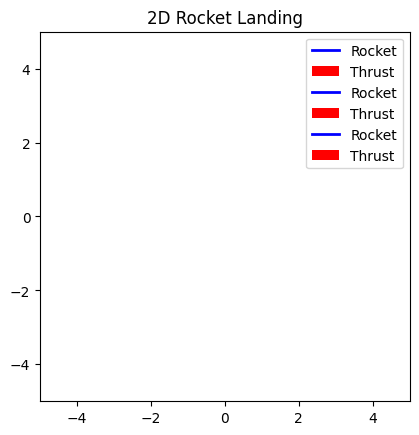

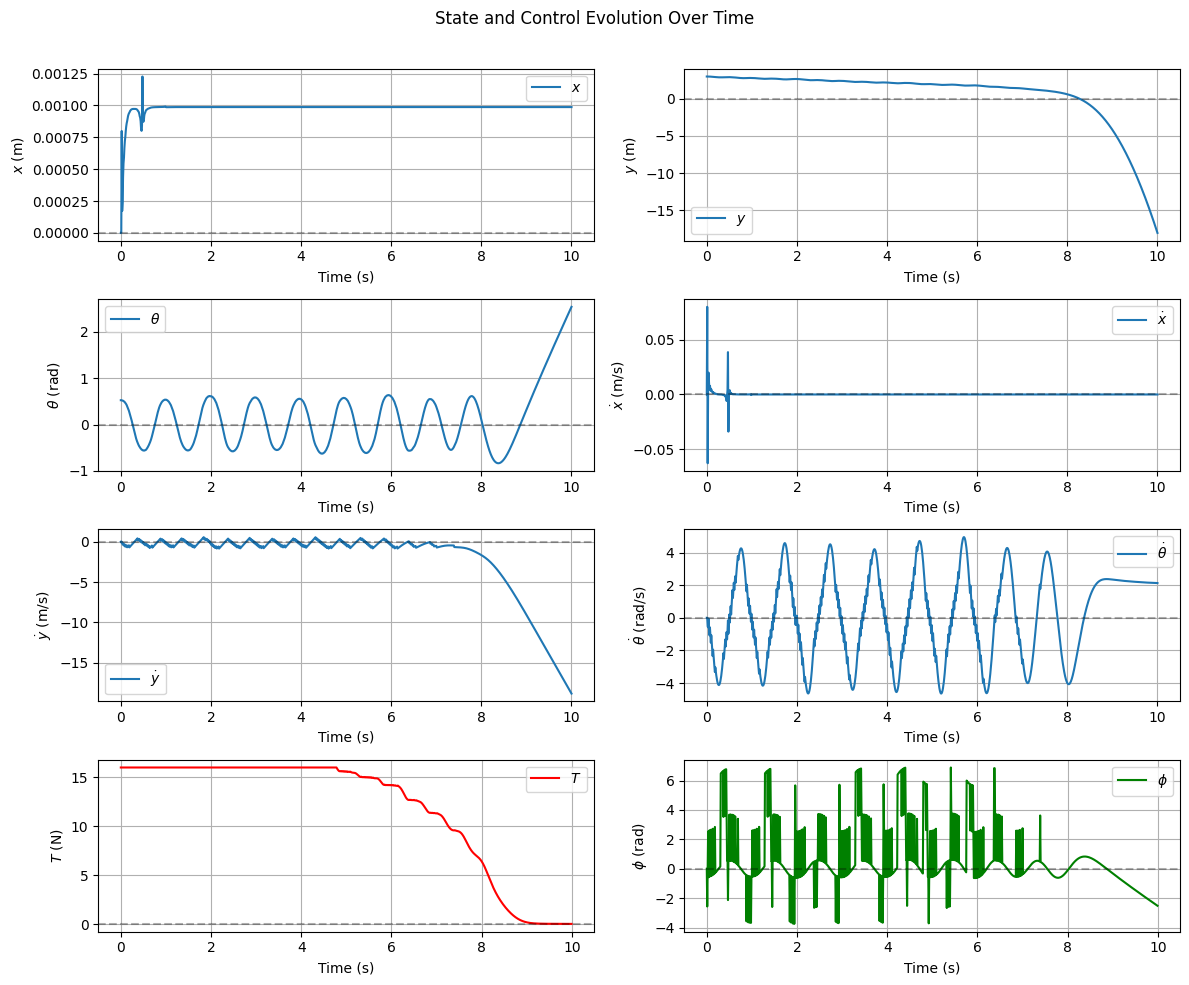

In [11]:
# Demo
initial_state = [0.0, 3.0,np.pi/6 , 0.0, 0.0, 0.0]
rocket = RocketPlant(initial_state, m=1.0, l=1.0)
controller = EnergyController(rocket, T_max=16)
sim = Simulation(rocket, controller, t_final=10.0)
sim.run()
animator = Animator(sim)
animation = animator.animate()
display(animation)
plot_states(sim)